# Detect depression via multi-modality fusion model

## problem origin
![](https://ae01.alicdn.com/kf/Heb28a641caab49d08b150179cc01bc22A.jpg)
![](https://ae01.alicdn.com/kf/Heed8e36271674f59bf8c421462b94d0bq.jpg)

## Raw Data - DAIC‐‑WOZ Depression Database
- VIDEO
    - XXX_CLNF_features.txt 
    - XXX_CLNF_features3D.txt
    - XXX_CLNF_gaze.txt
    - XXX_CLNF_hog.bin
    - XXX_CLNF_pose.txt
    - XXX_CLNF_AUs.csv
- AUDIO
    - XXX_AUDIO.wav
    - XXX_COVAREP.csv
    - XXX_FORMANT.csv
- TEXT
    - XXX_TRANSCRIPT.csv

In [78]:
import pandas as pd
import numpy as np
import scipy.stats
import os
import csv
from scipy.fftpack import dct, idct
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
"""
也不知道为什么，使用root为jupyterhub安装kernel后，在这里启动的python路径不含用户的site-package
而用户下安装的包就索引不到了。
切换到root用户使用此环境可以正常找到。。。

先记录下，之后再解决
"""
extra_path =  ['/home/yzk/.conda/envs/test/lib/python37.zip', 
    '/home/yzk/.conda/envs/test/lib/python3.7',
    '/home/yzk/.conda/envs/test/lib/python3.7/lib-dynload', 
    '/home/yzk/.conda/envs/test/lib/python3.7/site-packages']
import sys
sys.path += extra_path

### AUDIO

In [10]:
fold_dir = './data/avec/'
file_name = '301_P/301_AUDIO.wav'

In [133]:
import librosa
y, sr = librosa.load(fold_dir + file_name, duration=20)

### Original Signal  .wav

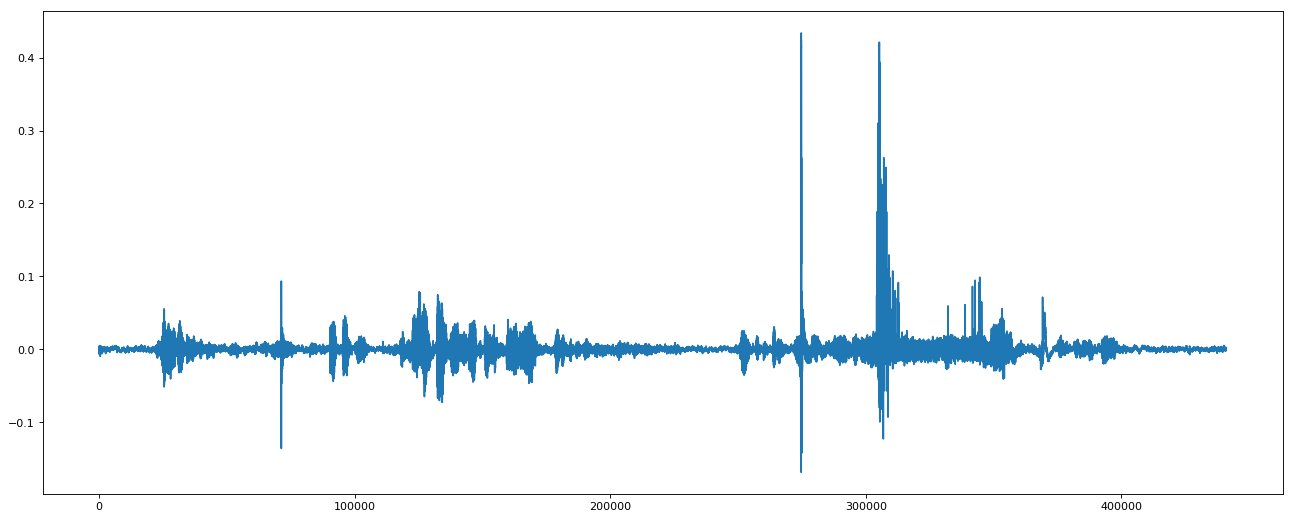

In [171]:
y.shape
plt.figure(figsize=(20,8),dpi=80)
plt.plot(np.arange(y.shape[0]), y)

### COVA.csv
![](https://ae01.alicdn.com/kf/Hbca79d941ba24e6abab54bcad274b8d4Y.jpg)

- **F0**:  primary acoustic correlate of pitch, used to represent periodicity of the speech signal
- **VUV**:  voiced or unvoiced {0, 1}
- NAQ: Glottal Flow Parameterisation
- QOQ: Glottal Flow Parameterisation
- H1H2: Glottal Flow Parameterisation
- PSP: Glottal Flow Parameterisation
- MDQ: Glottal Flow Parameterisation
- peakSlope: Spectral Envelope Estimation and Formant Trackin
- Rd: Phase Processing
- **Rd_conf**: Phase Processing
- **MCEP_0-­‐24**：Mell Cepctrum Coeificient
- HMPDM_0-­‐24
- HMPDD_0-­‐12

### FORMANT.csv

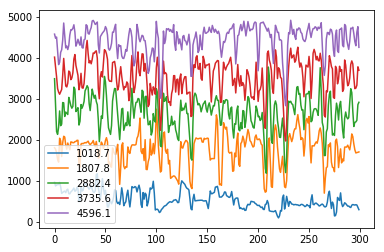

In [175]:
df_formant = pd.read_csv(fold_dir+'301_P/301_FORMANT.csv')
df_formant[:300].plot(kind='line')

### Spectural

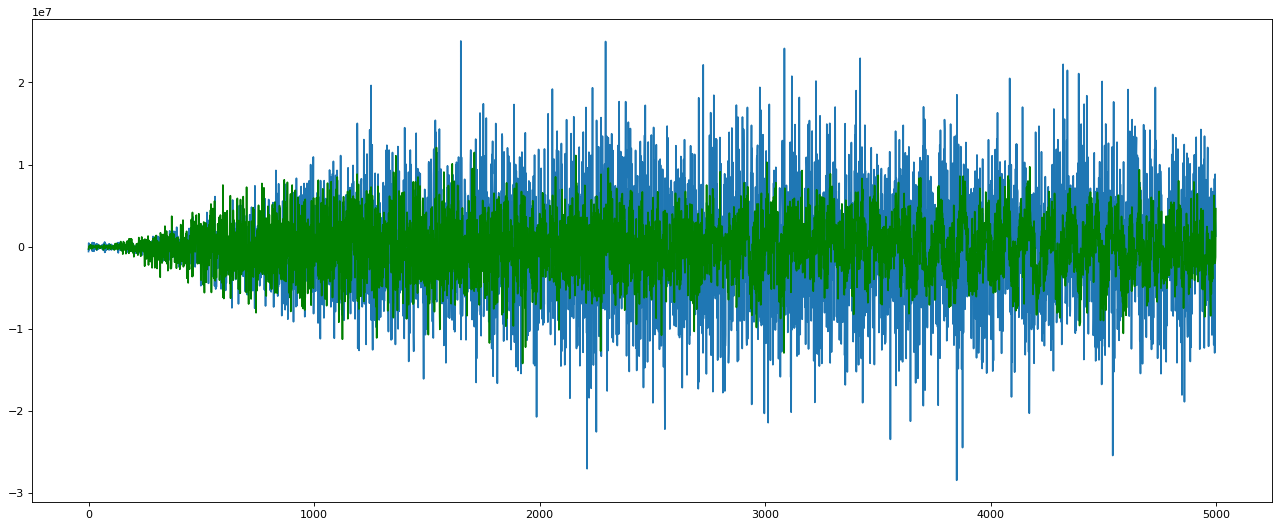

In [157]:
from scipy.fftpack import dct, fft
wave_dct = dct(wave_data)
wave_fft = fft(wave_data)
n = np.arange(wave_dct.shape[0])
plt.figure(figsize=(20,8),dpi=80)
plt.plot(n[:5000], wave_dct[:5000])
plt.plot(n[:5000], wave_fft[:5000], c='g')

### MFCC
<img src="https://pic.superbed.cn/item/5da9f7e3451253d1784daa91.jpg" style='height:400px; margin:30px'>

<img src="https://ae01.alicdn.com/kf/H26bb31a781c749b1b95efa62ee8a1768J.jpg" style='height:400px'>

### PLP (Perceptural Linear Prediction)
<img src="https://ae01.alicdn.com/kf/H5e89a68c827e40e68ad92cc0a4774b9fm.jpg" style='width:500px'>

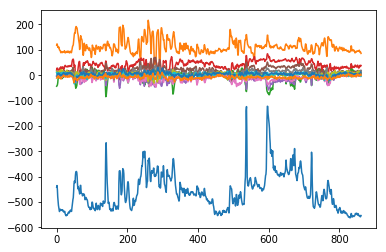

In [159]:
y, sr = librosa.load(fold_dir + file_name, duration=20)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
mfcc_df = pd.DataFrame(mfcc)
for i in range(mfcc.shape[0]):
    x = np.arange(mfcc.shape[1])
    plt.plot(x, mfcc[i, :])
plt.show()

### TEXT- TRANSCRIPT.txt

In [154]:
df_trans = pd.read_csv(fold_dir + '/301_P/301_TRANSCRIPT.csv', sep='\t')
df_trans.head()

,start_time,stop_time,speaker,value
0,29.428,35.888,Ellie,hi i'm ellie thanks for coming in today i was ...
1,32.738,33.068,Participant,thank you
2,36.598,40.948,Ellie,think of me as a friend i don't judge i can't ...
3,42.088,42.518,Participant,mmm k
4,42.358,51.738,Ellie,i'm here to learn about people and would love ...


## Paper Reproduct

![](https://puui.qpic.cn/fans_admin/0/3_1440820217_1571446916793/0)

![](https://ae01.alicdn.com/kf/Hcc1470eb1d0a4611ade6d987e0400a13t.jpg)

## Audio Feature
![](https://ae01.alicdn.com/kf/H05f436f108e2441eba81253f1d73e9df8.jpg)
![](https://ae01.alicdn.com/kf/H92a3e2b6ea344c178ace55fe4e1008445.jpg)

## Video Feature
![](https://ae01.alicdn.com/kf/He9dfa9f6933e4d84b1acfadb2133bc788.jpg)

## Text Feature
 -  Statistical of Words and Sentences
        - word \ sentence ratio per duration
        - laghter words instances ratio
 - the ratio of depression  related words
 - sentient value via **AFFIN**

In [160]:
# read input data
fea_audio = pd.read_csv(f'{fold_dir}audio_fea.csv', header = None)
fea_text = pd.read_csv(f'{fold_dir}text_fea.csv', header = None)

# read train/dev/test indicators
list_train = pd.read_csv('./data/train_split_Depression_AVEC2017.csv')
list_dev = pd.read_csv('./data/dev_split_Depression_AVEC2017.csv')
list_test = pd.read_csv('./data/test_split_Depression_AVEC2017.csv')

# list directory
dirlist = os.listdir(fold_dir)
list_fold = []
for fold in dirlist:
    if not fold.endswith('P'):
            continue
    list_fold.append(int(fold[:3]))

# get train/dev/test exactly
list_train = list_train.loc[[i in list_fold for i in list_train['Participant_ID'].tolist()],]
list_dev = list_dev.loc[[i in list_fold for i in list_dev['Participant_ID'].tolist()],]
list_test = list_test.loc[[i in list_fold for i in list_test['participant_ID'].tolist()],]

fea_audio = fea_audio.fillna(method='ffill')
# fea_audio_train = fea_audio.loc[[i in list_train['Participant_ID'].tolist() for i in list_fold],]
fea_text_train = fea_text.loc[[i in list_train['Participant_ID'].tolist() for i in list_fold],]
# fea_audio_dev = fea_audio.loc[[i in list_dev['Participant_ID'].tolist() for i in list_fold],]
fea_text_dev = fea_text.loc[[i in list_dev['Participant_ID'].tolist() for i in list_fold],]
# fea_audio_test = fea_audio.loc[[i in list_test['participant_ID'].tolist() for i in list_fold],]
fea_text_test = fea_text.loc[[i in list_test['participant_ID'].tolist() for i in list_fold],]

In [129]:
list_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [164]:
len(fea_audio), len(fea_text), len(list_train), len(list_dev), len(list_dev)

(187, 188, 107, 35, 35)

## Experienment

- identifying biomarkers that are predictiveto depression

- Investigating the gender-information on biomarkersExisting

- Investigating dominant biomarkers and theirsignificance